#Urdu Fake News Detection Using RNN 



In [3]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re 
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

Read the data 

In [4]:
fake_df = pd.read_csv('Fake.csv')
real_df = pd.read_csv('Real.csv')

Checking for null values 

In [5]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [6]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

Checking for unique values for subject. We want both data frames to have a similar distribution.

In [7]:
fake_df.subject.unique()

array(['News'], dtype=object)

In [8]:
real_df.subject.unique()

array(['News'], dtype=object)

Drop the date from the dataset, I don't think there is a strong correlation between date and validity of the news. As we see above, subjects are not distributed evenly. We do not want that to influence the accuracy of our classifier. Therefore, we need to drop that as well. 

In [9]:
fake_df.drop(['date', 'subject'], axis=1, inplace=True)
real_df.drop(['date', 'subject'], axis=1, inplace=True)

0 for fake news, and 1 for real news

In [10]:
fake_df['class'] = 0 
real_df['class'] = 1

Check out the distribution of fake news compare to real news

Text(0, 0.5, 'Proportion of News Articles')

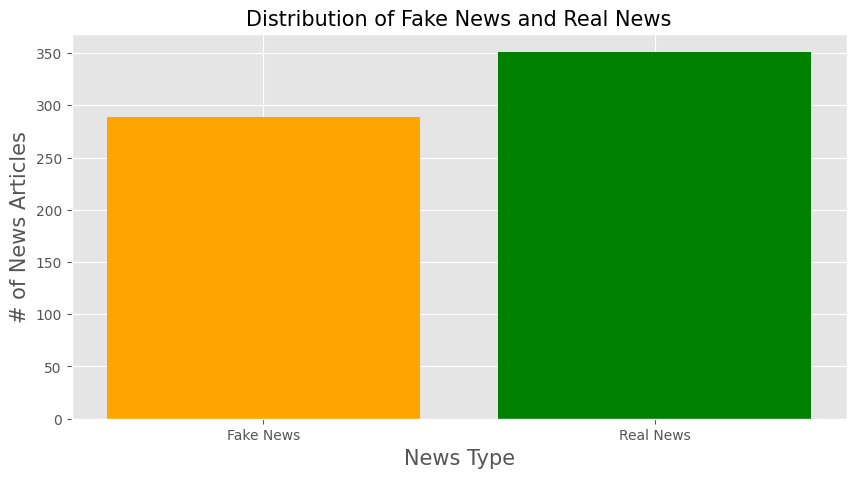

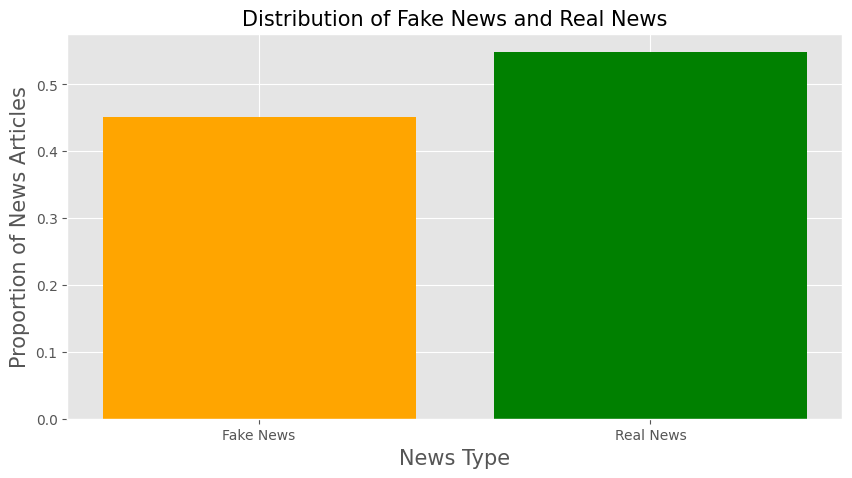

In [11]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df), color='orange')
plt.bar('Real News', len(real_df), color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('# of News Articles', size=15)


total_len = len(fake_df) + len(real_df)
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(fake_df) / total_len, color='orange')
plt.bar('Real News', len(real_df) / total_len, color='green')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Proportion of News Articles', size=15)

In [12]:
print('Difference in news articles:',len(fake_df)-len(real_df))

Difference in news articles: -62


In [13]:
news_df = pd.concat([fake_df, real_df], ignore_index=True, sort=False)
news_df

,title,text,class
0,Fake-News,﻿مرزا شاہد برلاس\n\nدماغی ذہانت (brain Intelli...,0
1,Fake-News,﻿\nایک برطانوی جريدے نے خبردار کیا ہے کہ جیسے ...,0
2,Fake-News,﻿بھاپ سے چلنے والی وہیل چیئرز کو روایتی طور پر...,0
3,Fake-News,یونیورسٹی آف نیوزی لینڈ کے سائنسدانوں کی تحقیق...,0
4,Fake-News,ممبئی (ڈیلی پاکستان آن لائن) بالی ووڈ اداکارہ ...,0
...,...,...,...
635,Real-News,لندن (ڈیلی پاکستان آن لائن ) پاکستانی اداکارہ ...,1
636,Real-News,امریکی ریاست کیلی فور نیا میں قائم اسٹینفرڈ یو...,1
637,Real-News,شیئر کریں:\n\nموبائل فون اور لیپ ٹاپ کو بےتحاش...,1
638,Real-News,نظر اتارنے کیلئے صدقہ دیا کرتی ہوں ،ایک دوسرے ...,1


Combining the title with the text, it is much easier to process this way. 

In [14]:
news_df['text'] = news_df['title'] + news_df['text']
news_df.drop('title', axis=1, inplace=True)

Split into training and testing 

In [15]:
features = news_df['text']
targets = news_df['class']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=18)

Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [16]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [17]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

Convert text to vectors, our classifier only takes numerical data. 

In [18]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Apply padding so we have the same length for each article 

In [19]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

Building the RNN.

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

We are going to use early stop, which stops when the validation loss no longer improve.

In [21]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
16/16 [==============================] - 20s 373ms/step - loss: 0.6931 - accuracy: 0.4457 - val_loss: 0.6918 - val_accuracy: 0.4423
Epoch 2/10
16/16 [==============================] - 4s 243ms/step - loss: 0.6914 - accuracy: 0.4457 - val_loss: 0.6909 - val_accuracy: 0.4423
Epoch 3/10
16/16 [==============================] - 4s 253ms/step - loss: 0.6895 - accuracy: 0.4457 - val_loss: 0.6895 - val_accuracy: 0.4423
Epoch 4/10
16/16 [==============================] - 4s 230ms/step - loss: 0.6874 - accuracy: 0.4457 - val_loss: 0.6883 - val_accuracy: 0.4423
Epoch 5/10
16/16 [==============================] - 3s 200ms/step - loss: 0.6849 - accuracy: 0.4457 - val_loss: 0.6865 - val_accuracy: 0.4423
Epoch 6/10
16/16 [==============================] - 4s 248ms/step - loss: 0.6824 - accuracy: 0.4457 - val_loss: 0.6844 - val_accuracy: 0.4423
Epoch 7/10
16/16 [==============================] - 4s 233ms/step - loss: 0.6781 - accuracy: 0.4457 - val_loss: 0.6823 - val_accuracy: 0.4423
Epoch

Visualize our training over time 

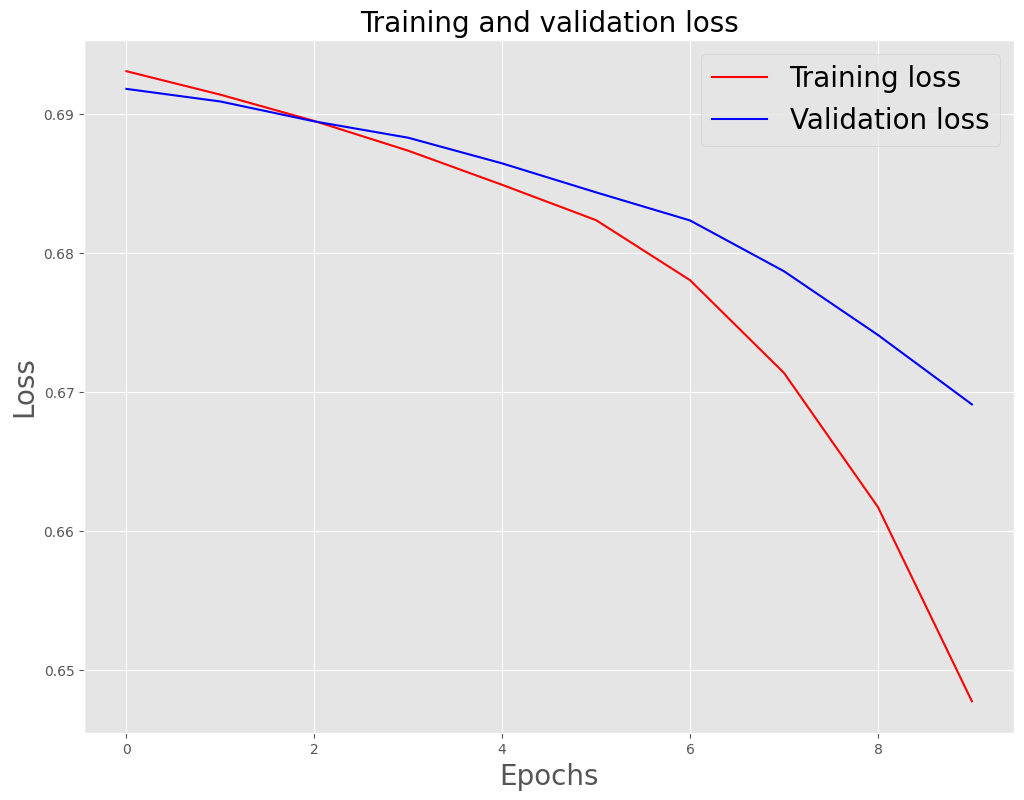

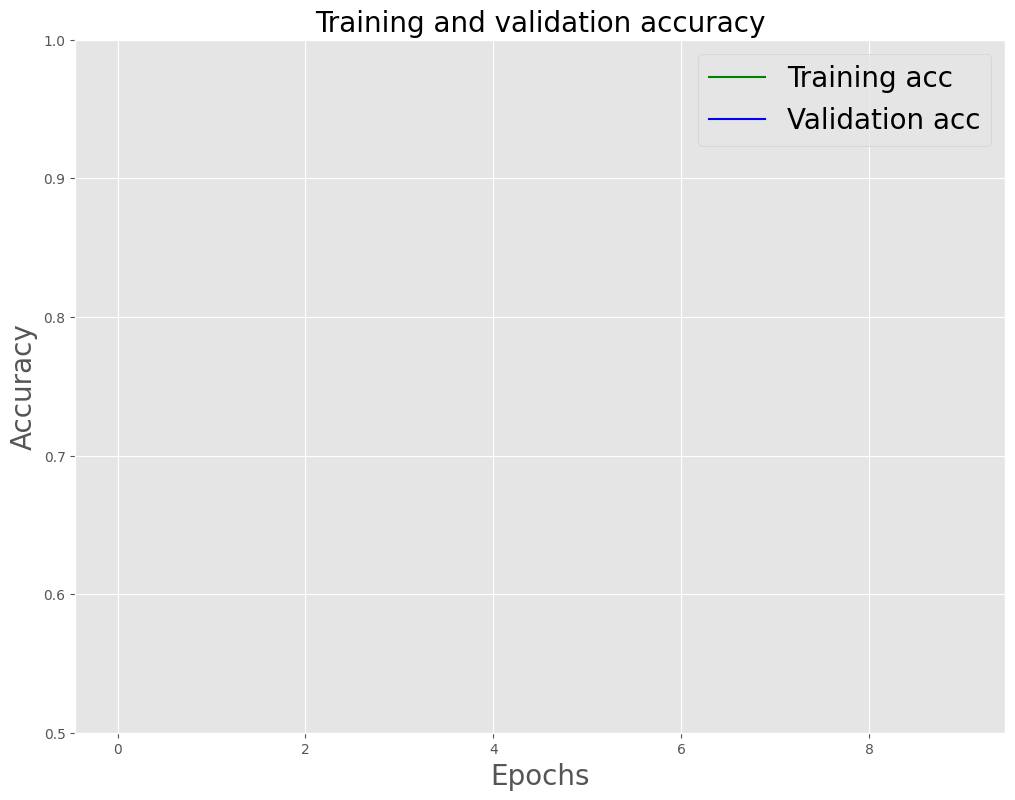

In [22]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

Evaluate the testing set 

In [23]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 29ms/step - loss: 0.6757 - accuracy: 0.4766


[0.6756962537765503, 0.4765625]

In [24]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

4/4 [==============================] - 1s 22ms/step


In [25]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.4765625
Precision on testing set: 0.0
Recall on testing set: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix 

[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

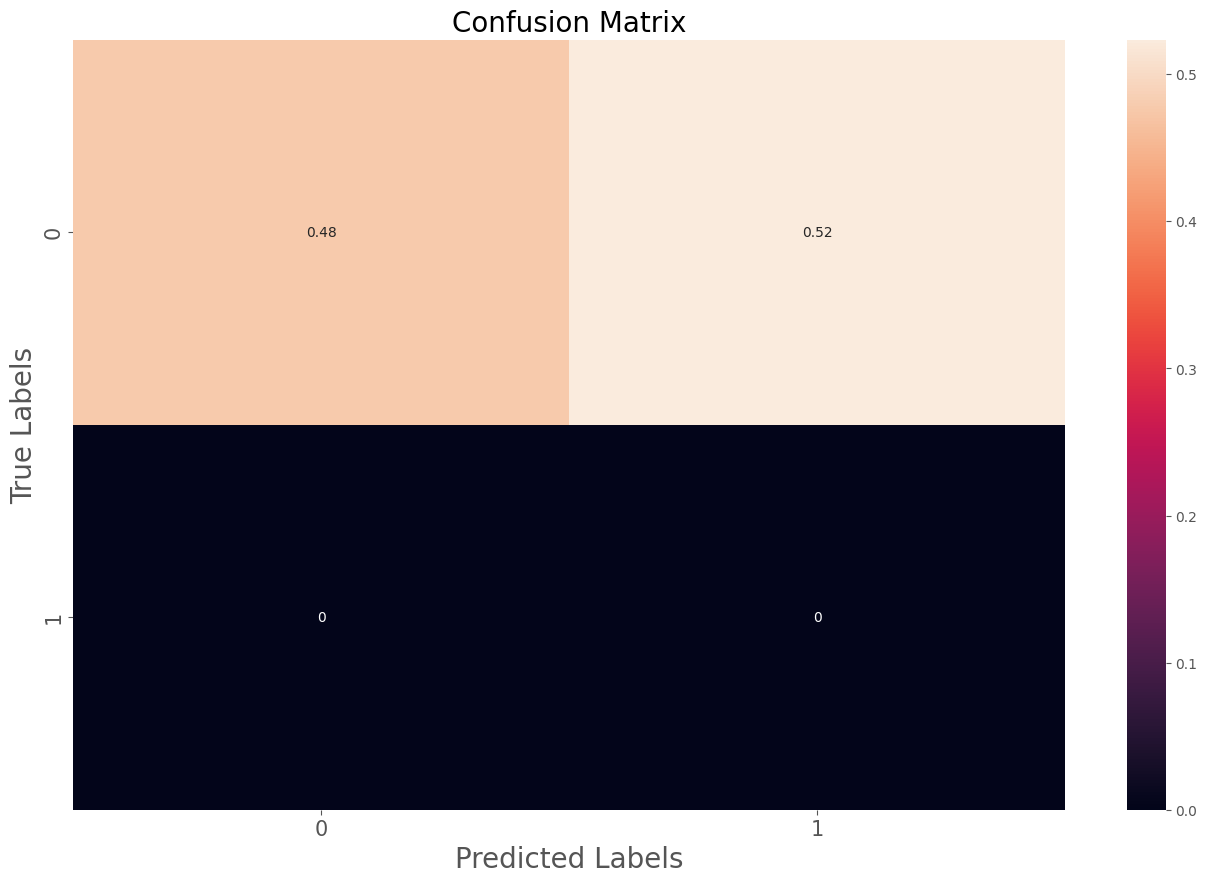

In [26]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)

Saves the weights for visualiation

In [27]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 128)


In [28]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

Write to file so we can use tensorflow's embedding projector to visualize what our network learned. This is only based on the fake news dataset. 

In [29]:
import io

out_v = io.open('fakenews_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('fakenews_meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(word_index):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

Embedding Projector: http://projector.tensorflow.org/
<br>Picture credits: https://www.tensorflow.org/tensorboard/images/embedding_projector.png?raw=1

![](https://www.tensorflow.org/tensorboard/images/embedding_projector.png?raw=1)